# Team 11: Predicting the Impact of Twitter Posts on Bitcoin Prices

**Group Members:**  Andrey Bartashevich (14586517), Finn Prins (13458434), Duco Trompert (14591227)

**Research Question:** Can Twitter (a.k.a. X) posts of famous people influence the prices of Bitcoin?

# Hypothesis: 
**Null hypothesis:** There is no impact of Twitter  posts by individuals with over one million followers on the Bitcoin price movements.

**Alternative Hypothesis:** There is an impact of Twitter posts by individuals with over one million followers on the Bitcoin price movements


**Potentialy change the 1 mill foloowers with 250 000 followers, because the dataset doesnt have enough values for users with 1 000 000 followers.**

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
from langdetect import DetectorFactory

**Data Processing**

Bitcoin dataset

In [2]:
# First btc price is 2012-01-01
# Last btc price is 2024-11-28

# First tweet is 2007-04-19
# Last tweet is 2019-11-23

# Data from 2012-01-01 to 2019-11-23 is valuable

# Date interval
start_day = "2012-01-01"
end_day = "2019-11-23"


# Open bitcoin csv
bitcoin = pd.read_csv('data/btcusd_1-min_data.csv')
# Renaming timestamp, Close, and Volume columns
bitcoin.rename(columns={'Timestamp': 'date', 'Close': 'price', 'Volume': 'volume'}, inplace=True)
# Convert to datetime and filter by date interval
bitcoin['date'] = pd.to_datetime(bitcoin['date'], unit='s')
bitcoin = bitcoin[(bitcoin['date'] >= start_day) & (bitcoin['date'] <= end_day)]
# Convert to daily granularity
bitcoin['date'] = bitcoin['date'].dt.date
bitcoin = bitcoin.groupby('date').agg(
    first_price=('price', 'first'),  # First price of the day
    last_price=('price', 'last'),   # Last price of the day
    price=('price', 'last'),   # Last closing price of the day
    volume=('volume', 'sum')   # Total daily volume
).reset_index()
bitcoin['change'] = bitcoin['last_price'] - bitcoin['first_price']
bitcoin['change'] = bitcoin['change'].fillna(0)
bitcoin = bitcoin[['date', 'price', 'change', 'volume']]


# Print processed Bitcoin data
print(f"Length: {len(bitcoin)}")
print(bitcoin.head())

Length: 2884
         date  price  change      volume
0  2012-01-01   4.84    0.26   10.000000
1  2012-01-02   5.00    0.16   10.100000
2  2012-01-03   5.29    0.29  107.085281
3  2012-01-04   5.57    0.28  107.233260
4  2012-01-05   6.42    0.85   70.328742


Twitter dataset

In [3]:
# Open twitter csv
tweet = pd.read_csv('data/tweets.csv', delimiter=';', lineterminator='\n')
# Rename timestamp and text\r columns
tweet.rename(columns={'timestamp': 'date', 'text\r': 'text'}, inplace=True)
# Convert to datetime and filter by date interval
tweet['date'] = pd.to_datetime(tweet['date']).dt.tz_localize(None)
tweet = tweet[(tweet['date'] >= start_day) & (tweet['date'] <= end_day)]
# Convert to daily granularity
tweet['date'] = tweet['date'].dt.date
# Drop unnecessary columns
tweet = tweet[['date', 'likes', 'replies', 'retweets', 'text']]

# Print processed Twitter data
print(f"Length: {len(tweet)}")
print(tweet.head())

/tmp/ipykernel_607376/329435101.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet = pd.read_csv('data/tweets.csv', delimiter=';', lineterminator='\n')


Length: 16853515
         date  likes  replies  retweets  \
0  2019-05-27      0        0         0   
1  2019-05-27      0        0         0   
2  2019-05-27      2        0         1   
3  2019-05-27      0        0         0   
4  2019-05-27      0        0         0   

                                                text  
0  È appena uscito un nuovo video! LES CRYPTOMONN...  
1  Cardano: Digitize Currencies; EOS https://t.co...  
2  Another Test tweet that wasn't caught in the s...  
3  Current Crypto Prices! \n\nBTC: $8721.99 USD\n...  
4  Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...  


Normalized total impressions calculation

In [4]:
impressions = tweet.groupby('date').agg(
    likes=('likes', 'sum'),  # Sum of likes per day
    replies=('replies', 'sum'),  # Sum of replies per day
    retweets=('retweets', 'sum'),  # Sum of retweets per day
).reset_index()
# Calculate average likes, replies and retweets
avg_likes = tweet['likes'].mean()
avg_replies = tweet['replies'].mean()
avg_retweets = tweet['retweets'].mean()
# Print average likes, replies and retweets
print(f"Average likes: {avg_likes}")
print(f"Average replies: {avg_replies}")
print(f"Average retweets: {avg_retweets}")
# Add normalized total impressions
impressions['total'] = 1 / avg_likes * impressions['likes'] + \
                             1 / avg_replies * impressions['replies'] + \
                             1 / avg_retweets * impressions['retweets']

print(f"Length: {len(impressions)}")
print(impressions.head())

Average likes: 2.66385540345738
Average replies: 0.3142164112352824
Average retweets: 1.049500000445011
Length: 2884
         date  likes  replies  retweets     total
0  2012-01-01      2        0         1  1.703626
1  2012-01-02      0        0         0  0.000000
2  2012-01-03      0        0         0  0.000000
3  2012-01-04      0        2         0  6.365040
4  2012-01-05      0        0         0  0.000000


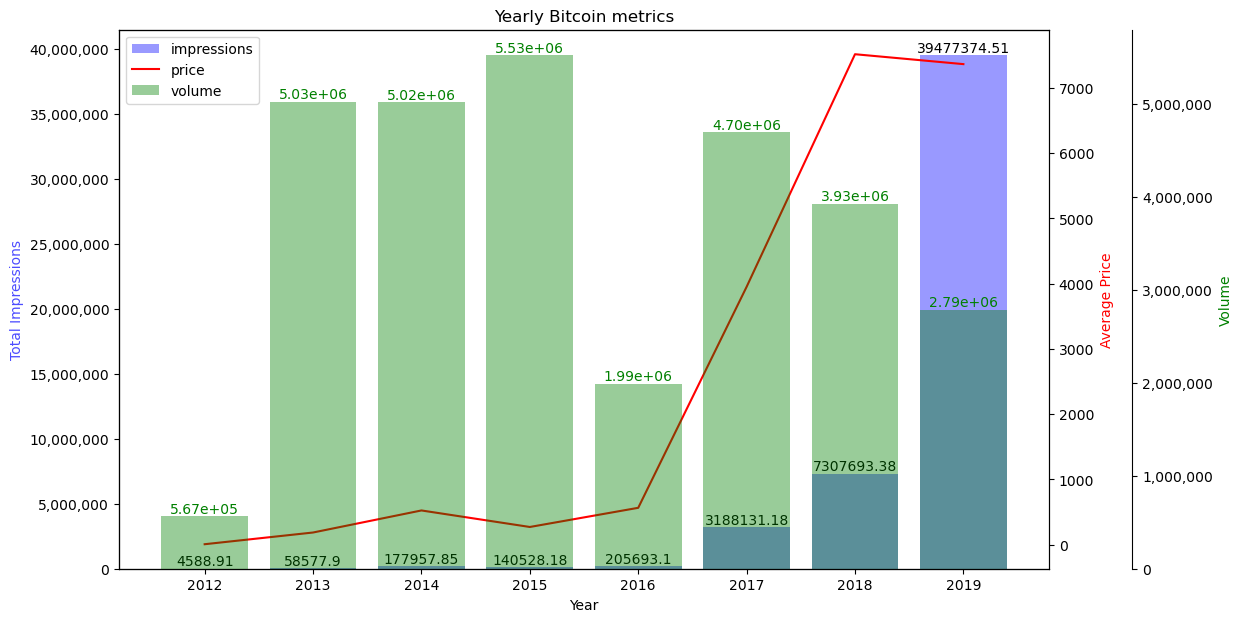

In [5]:
# date time conversion
impressions['date'] = pd.to_datetime(impressions['date'])
#only taking year for date
impressions['year'] = impressions['date'].dt.year
bitcoin['date'] = pd.to_datetime(bitcoin['date'])

# calculations of yearly matrices
year_impressions = impressions.groupby('year')['total'].sum().reset_index()
year_volume = bitcoin.groupby(bitcoin['date'].dt.year)['volume'].sum().reset_index()
year_price = bitcoin.groupby(bitcoin['date'].dt.year)['price'].mean().reset_index()

# changing the name of date on year and price
year_volume = year_volume.rename(columns={'date': 'year'})
year_price = year_price.rename(columns={'date': 'year'})

#plot
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

# prevent overlap on y axis
ax3.spines['right'].set_position(('outward', 60))
# impressions
bars_impressions = ax1.bar(year_impressions['year'], year_impressions['total'],  alpha=0.4, color='blue', label='impressions')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#impression bar labels
for i, v in enumerate(year_impressions['total']):
    ax1.text(year_impressions['year'][i], v, round(v, 2), ha='center', va='bottom')

# bitcoin price
line = ax2.plot(year_price['year'], year_price['price'],color='red', label='price')

# volume
bars_volume = ax3.bar(year_volume['year'], year_volume['volume'], alpha=0.4, color='green', label='volume')
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
#volume bar labels (using scientific notation for visual interpretation)
for i, v in enumerate(year_volume['volume']):
    ax3.text(year_volume['year'][i], v, f'{v:.2e}', ha='center', va='bottom', color='green')

ax1.set_xlabel('Year')
ax1.set_ylabel('Total Impressions', color='blue', alpha=0.7)
ax2.set_ylabel('Average Price', color='red')
ax3.set_ylabel('Volume', color='green')
plt.title('Yearly Bitcoin metrics')
# legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
plt.show()

**Filter only english tweets and sentiment analysis**

In [6]:
# Set seed for consistency of results
DetectorFactory.seed = 0


# Detection of english tweets amoung tweets
def is_english(text):
    try:
        # Check if the line is Nan or empty
        if pd.isna(text) or text.strip() == '':
            return False
        # Using detect function to find english text
        return detect(text) == 'en'
    except:
         return False


# Sentiment analysis using vader library
def vader_sentiment(text):
        # Starting vader module for text analysis
        analyzer = SentimentIntensityAnalyzer()
        # Geting sentiment scores on a scale from -1 to 1 as a dictionary (compound)
        scores = analyzer.polarity_scores(text)
        # Calcualting the sentiment of each text based on the compund score
        # Positive
        if scores['compound'] >= 0.05:
            sentiment = 1
        # Negative
        elif scores['compound'] <= -0.05:
            sentiment = -1
        # Neutral
        else:
            sentiment = 0

        return {'sentiment':sentiment, 'compound':scores['compound']}

**Data visualization**

/home/duco/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


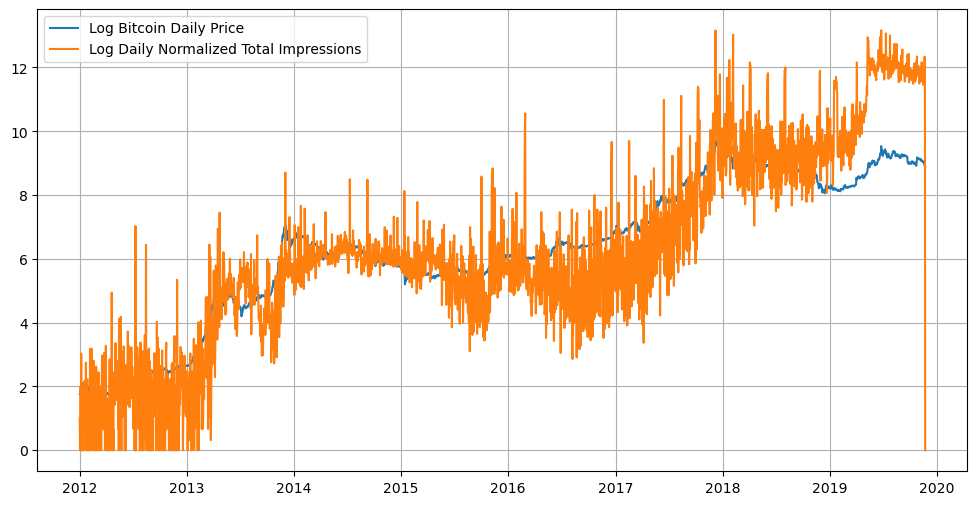

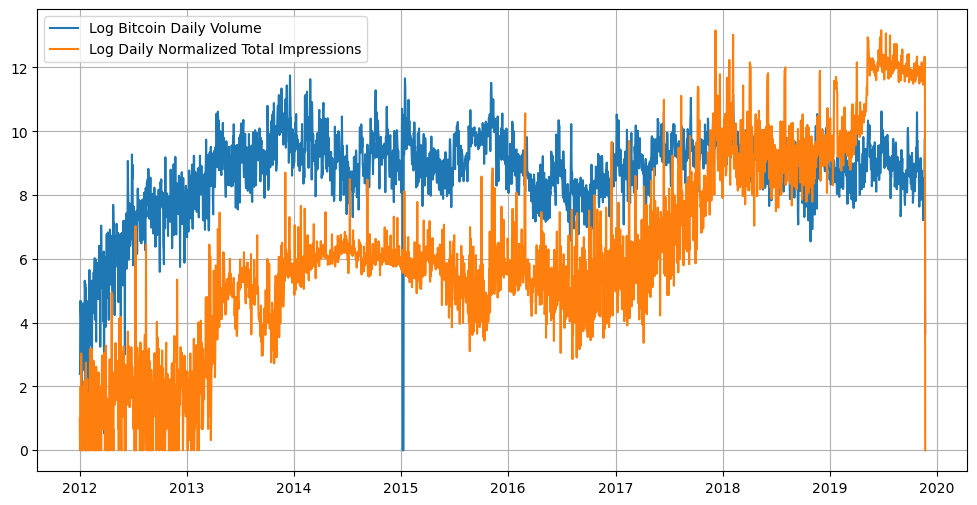

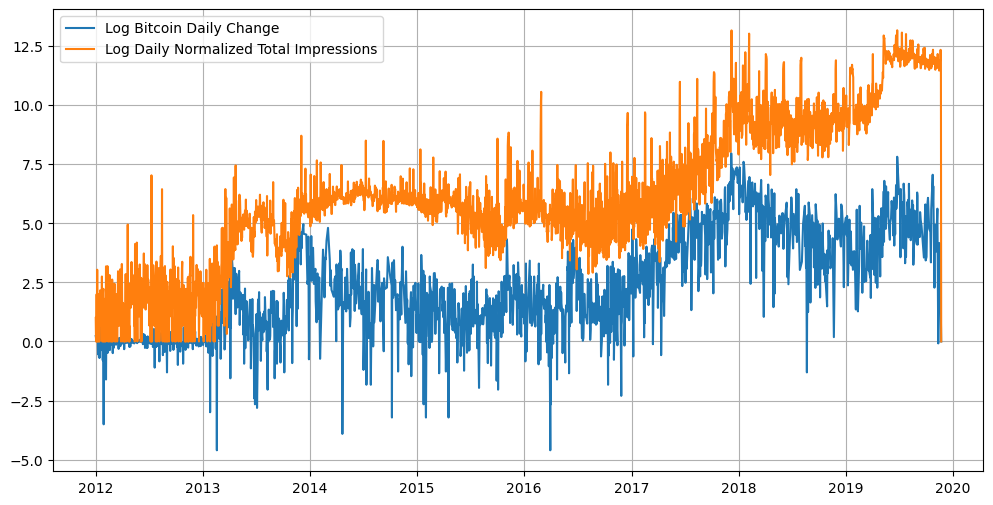

In [7]:
date_range = pd.date_range(start=start_day, end=end_day)
date_df = pd.DataFrame({'date': date_range.date})
date_df['date'] = pd.to_datetime(date_df['date'])

impressions['date'] = pd.to_datetime(impressions['date'])
impressions = pd.merge(date_df, impressions, on='date', how='left')
impressions = impressions.fillna(0)

bitcoin['date'] = pd.to_datetime(bitcoin['date'])
bitcoin = pd.merge(date_df, bitcoin, on='date', how='left')
bitcoin = bitcoin.fillna(0)

# Adding 1 to avoid log(0) and interpolting for missing values
log_price = np.log(bitcoin['price'] + 1).interpolate(method='linear')
log_volume = np.log(bitcoin['volume'] + 1).interpolate(method='linear')
log_change = np.log(bitcoin['change'] + 1).interpolate(method='linear')
log_impressions = np.log(impressions['total'] + 1).interpolate(method='linear')

# plt.figure(figsize=(12, 6))
# plt.plot(bitcoin['date'], bitcoin['price'], label='Bitcoin Daily Price')
# plt.plot(impressions['date'], impressions['total'], label='Daily Normalized Total Impressions')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin['date'], log_price, label='Log Bitcoin Daily Price')
plt.plot(impressions['date'], log_impressions, label='Log Daily Normalized Total Impressions')
plt.legend()
plt.grid(True)
plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(bitcoin['date'], bitcoin['volume'], label='Bitcoin Daily Price')
# plt.plot(impressions['date'], impressions['total'], label='Daily Normalized Total Impressions')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin['date'], log_volume, label='Log Bitcoin Daily Volume')
plt.plot(impressions['date'], log_impressions, label='Log Daily Normalized Total Impressions')
plt.legend()
plt.grid(True)
plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(bitcoin['date'], bitcoin['change'], label='Bitcoin Daily Price')
# plt.plot(impressions['date'], impressions['total'], label='Daily Normalized Total Impressions')
# plt.legend()
# plt.grid(True)
# plt.show()

plt.figure(figsize=(12, 6))
plt.plot(bitcoin['date'], log_change, label='Log Bitcoin Daily Change')
plt.plot(impressions['date'], log_impressions, label='Log Daily Normalized Total Impressions')
plt.legend()
plt.grid(True)
plt.show()

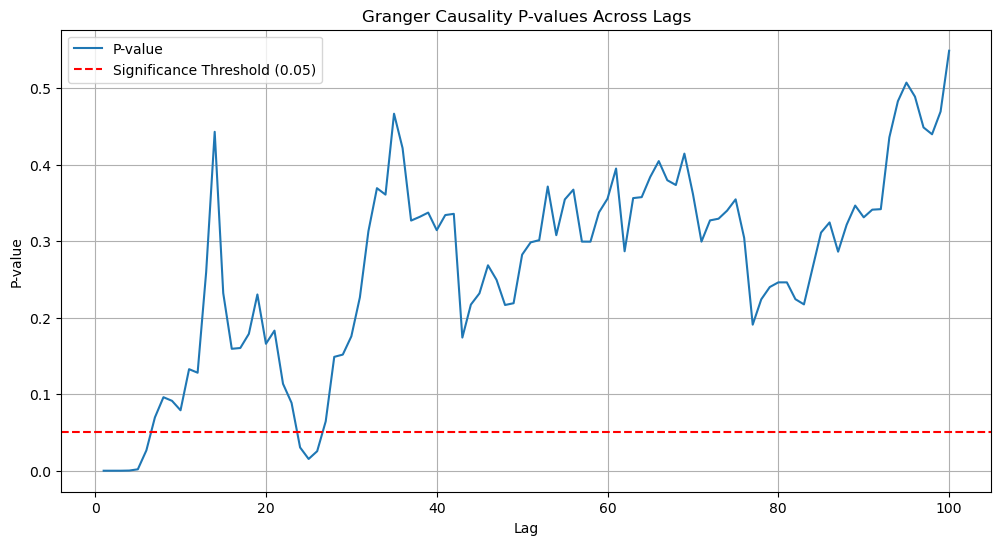

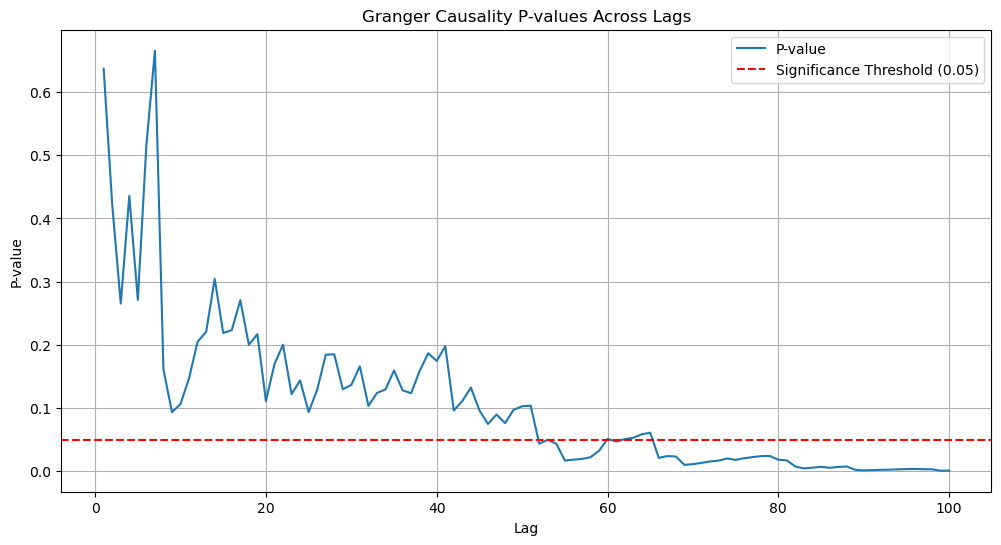

In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

lag = 100

results = grangercausalitytests(pd.concat([log_volume, log_impressions], axis=1), maxlag=lag, verbose=False)

p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values Across Lags')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

results = grangercausalitytests(pd.concat([log_price, log_impressions], axis=1), maxlag=lag, verbose=False)

p_values = [results[lag][0]['ssr_ftest'][1] for lag in range(1, lag + 1)]

plt.figure(figsize=(12, 6))
plt.plot(range(1, lag + 1), p_values, label='P-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Threshold (0.05)')
plt.title('Granger Causality P-values Across Lags')
plt.xlabel('Lag')
plt.ylabel('P-value')
plt.legend()
plt.grid(True)
plt.show()

**Pearson correlation coefficient**

The Pearson correlation coefficient (denoted as $r$) is calculated as:

$r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}$

Where:
- $\text{Cov}(X, Y)$ is the covariance between $X$ and $Y$, which measures how much the two variables change together.
- $\sigma_X$ and $\sigma_Y$ are the standard deviations of $X$ and $Y$, which measure the variability in each variable.

Key points:
- Assumes a linear relationship and requires continuous, normally distributed variables.
- Sensitive to outliers.
- $r = 1$ shows a perfect positive linear correlation.
- $r = -1$ shows a perfect negative linear correlation.
- $r = 0$ shows no linear correaltion.

In [9]:
# Calculate mean
def mean(X):
    return sum(X) / len(X)


# Calculate standard deviation
def standard_deviation(X):
    n = len(X)
    mean_X = mean(X)

    squared_differences = [(x - mean_X)**2 for x in X]

    variance = sum(squared_differences) / n

    std_dev = variance**0.5

    return std_dev


# Calculate covariance
def covariance(X, Y):
    mean_X = mean(X)
    mean_Y = mean(Y)

    deviations_product = [(x - mean_X) * (y - mean_Y) for x, y in zip(X, Y)]

    covariance = sum(deviations_product) / len(X)

    return covariance


# Calculate Pearson correlation coefficient
def pearson_correlation(X, Y):
    covariance_XY = covariance(X, Y)
    std_X = standard_deviation(X)
    std_Y = standard_deviation(Y)
    return covariance_XY / (std_X * std_Y)


# Calculate and print several Pearson correlation coefficients
pcc = pearson_correlation(log_price, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:\n{pcc}")

pcc = pearson_correlation(log_volume, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:\n{pcc}")

pcc = pearson_correlation(log_change, log_impressions)
print(f"The Pearson correlation coefficient between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:\n{pcc}")

The Pearson correlation coefficient between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:
0.8968751750195144
The Pearson correlation coefficient between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:
0.43536160840694843
The Pearson correlation coefficient between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:
0.7525672791338566


**Spearman Rank Correlation**

The Spearman rank correlation coefficient (denoted as $\rho$) measures the strength and direction of a monotonic relationship between two variables.

$\rho = 1 - \frac{6 \sum d_i^2}{n (n^2 - 1)}$

Where:
- $d_i$ is the difference between the ranks of corresponding values in $X$ and $Y$.
- $n$ is the number of data points.

Key points:
- Converts the data to ranks, making it a **non-parametric measure**.
- $\rho = 1$: perfect positive monotonic relationship.
- $\rho = -1$: perfect negative monotonic relationship.
- $\rho = 0$: no monotonic relationship.

In [10]:
# Rank the data
def rank(data):
    return [sorted(data).index(x) + 1 for x in data]


# Calculate Spearman rank correlation
def spearman_correlation(X, Y):
    n = len(X)
    rank_X = rank(X)
    rank_Y = rank(Y)
    d_squared = [(rx - ry) ** 2 for rx, ry in zip(rank_X, rank_Y)]
    rho = 1 - (6 * sum(d_squared)) / (n * (n**2 - 1))
    return rho


# Calculate and print several Spearman rank correlations
src = spearman_correlation(log_price, log_impressions)
print(f"The Spearman rank correlations between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:\n{src}")

src = spearman_correlation(log_volume, log_impressions)
print(f"The Spearman rank correlations between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:\n{src}")

src = spearman_correlation(log_change, log_impressions)
print(f"The Spearman rank correlations between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:\n{src}")

The Spearman rank correlations between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:
0.8536898374818025
The Spearman rank correlations between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:
0.3742728593119582
The Spearman rank correlations between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:
0.7577646301909984


**Kendall Tau Correlation**

The Kendall Tau correlation (denoted as $\tau$) evaluates the degree of concordance between two ranked variables.

$\tau = \frac{C - D}{\frac{1}{2}n(n-1)}$

Where:
- $C$ is the number of concordant pairs (pairs of points $(X_i, Y_i)$ and $(X_j, Y_j)$ where the order is the same).
- $D\$ is the number of discordant pairs (pairs of points where the order is reversed).
- $n$ is the total number of points.

Key points:
- A **non-parametric measure** suited for ordinal data.
- $\tau = 1$: perfect agreement in ranks.
- $\tau = -1$: perfect disagreement in ranks.
- $\tau = 0$: no association.

In [11]:
# Calculate Kendall Tau correlation
def kendall_tau(X, Y):
    n = len(X)
    concordant = 0
    discordant = 0
    for i in range(n):
        for j in range(i + 1, n):
            if (X[i] - X[j]) * (Y[i] - Y[j]) > 0:
                concordant += 1
            elif (X[i] - X[j]) * (Y[i] - Y[j]) < 0:
                discordant += 1
    tau = (concordant - discordant) / (0.5 * n * (n - 1))
    return tau


ktc = kendall_tau(log_price, log_impressions)
print(f"The Kendall Tau correlation between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:\n{ktc}")

ktc = kendall_tau(log_volume, log_impressions)
print(f"The Kendall Tau correlation between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:\n{ktc}")

ktc = kendall_tau(log_change, log_impressions)
print(f"The Kendall Tau correlation between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:\n{ktc}")

The Kendall Tau correlation between the logarithm of Bitcoin price and the logarithm of normalized total impressions is:
0.6629356267526458
The Kendall Tau correlation between the logarithm of Bitcoin volume and the logarithm of normalized total impressions is:
0.2522888730772913
The Kendall Tau correlation between the logarithm of Bitcoin change and the logarithm of normalized total impressions is:
0.5543253459107697


**Cross-Correlation**

Cross-correlation quantifies the similarity between two time series $X$ and $Y$ as a function of the lag (shift in time) between them.

$r_\text{lag} = \frac{\sum (X_t - \bar{X})(Y_{t+\text{lag}} - \bar{Y})}{\sqrt{\sum (X_t - \bar{X})^2 \sum (Y_{t+\text{lag}} - \bar{Y})^2}}$

Where:
- $\bar{X}$ and $\bar{Y}$ are the means of $X$ and $Y$, respectively.
- The numerator computes the covariance between $X$ and a lagged version of $Y$.

Key points:
- Often used in signal processing or time series analysis.
- Determines how $X$ and $Y$ relate when one is shifted relative to the other.
- Can identify lead-lag relationships.

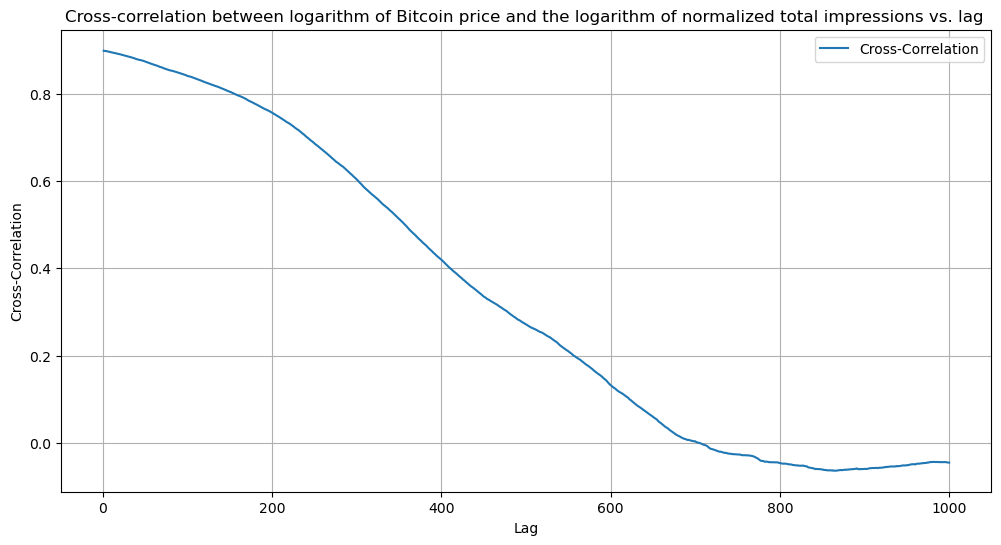

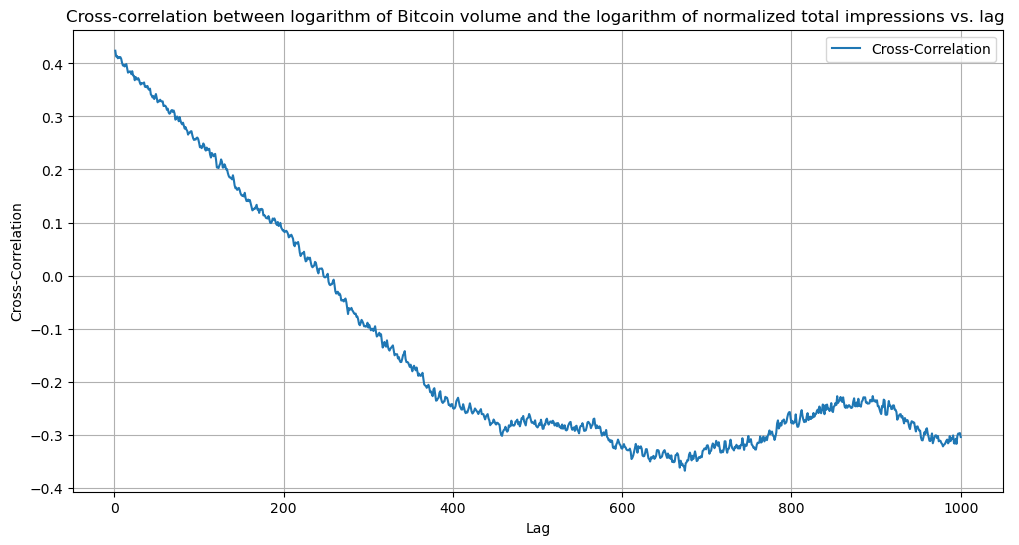

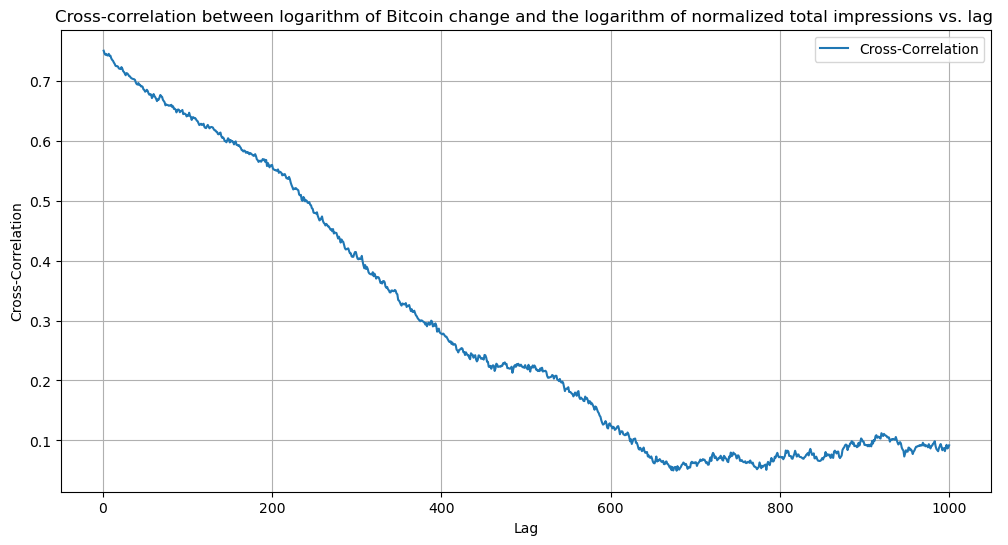

In [12]:
# Calculate Cross-Correlation
def cross_correlation(X, Y, lag):
    n = len(X)
    mean_X = mean(X)
    mean_Y = mean(Y)
    if lag < 0:
        lag = -lag
        X, Y = Y[lag:], X[:-lag]
    else:
        X, Y = X[lag:], Y[:-lag]
    numerator = sum((x - mean_X) * (y - mean_Y) for x, y in zip(X, Y))
    denominator = (sum((x - mean_X) ** 2 for x in X) * sum((y - mean_Y) ** 2 for y in Y)) ** 0.5
    return numerator / denominator

max_lag = 1000

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_price, log_impressions, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between logarithm of Bitcoin price and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_volume, log_impressions, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between logarithm of Bitcoin volume and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [cross_correlation(log_change, log_impressions, lag=lag) for lag in range(1, max_lag + 1)], label='Cross-Correlation')
plt.title('Cross-correlation between logarithm of Bitcoin change and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

**Granger Causality Test**

Granger causality tests whether changes in one time series ($X$) can predict changes in another ($Y$), implying a directional causal relationship.

Steps:
1. Fit a restricted model: Regress $Y_t$ on its past values.
2. Fit a full model: Regress $Y_t$ on its past values **and** past values of $X_t$.
3. Compute the F-statistic:

$F = \frac{(RSS_r - RSS_f) / (k_f - k_r)}{RSS_f / (n - k_f)}$

   Where:
   - $RSS_r$: Residual sum of squares from the restricted model.
   - $RSS_f$: Residual sum of squares from the full model.
   - $k_r, k_f$: Number of parameters in restricted and full models.
   - $n$: Number of observations.

Key points:
- A **statistical test** rather than a measure of correlation.
- Indicates whether $X$ "Granger-causes" $Y$ based on predictive power.
- Does not prove true causation, only predictive influence.

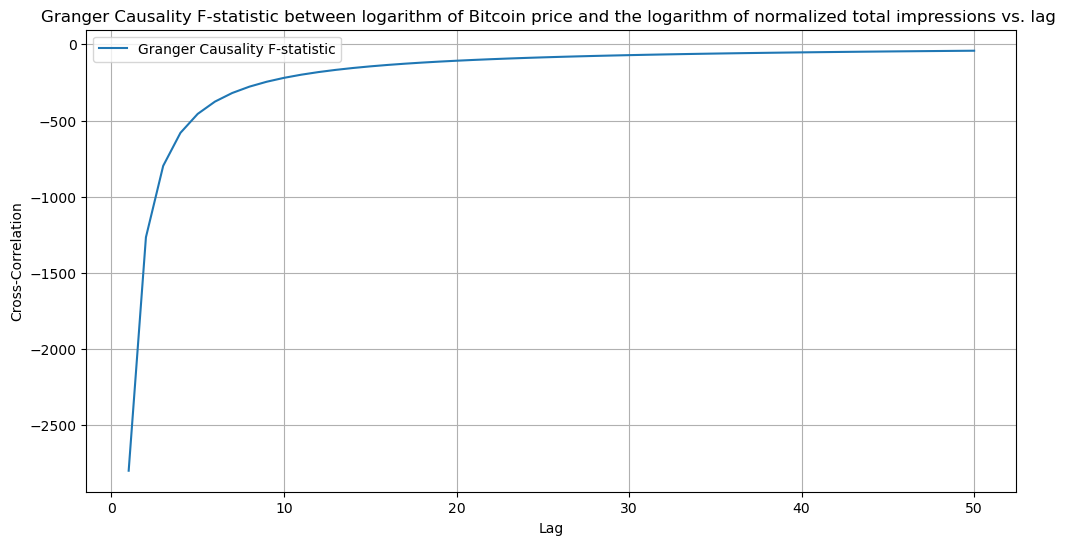

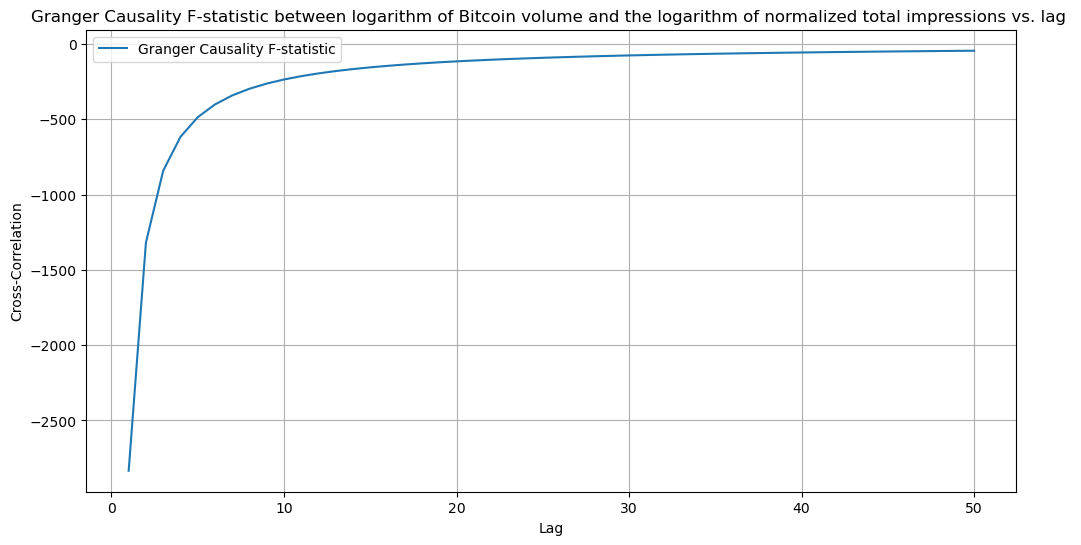

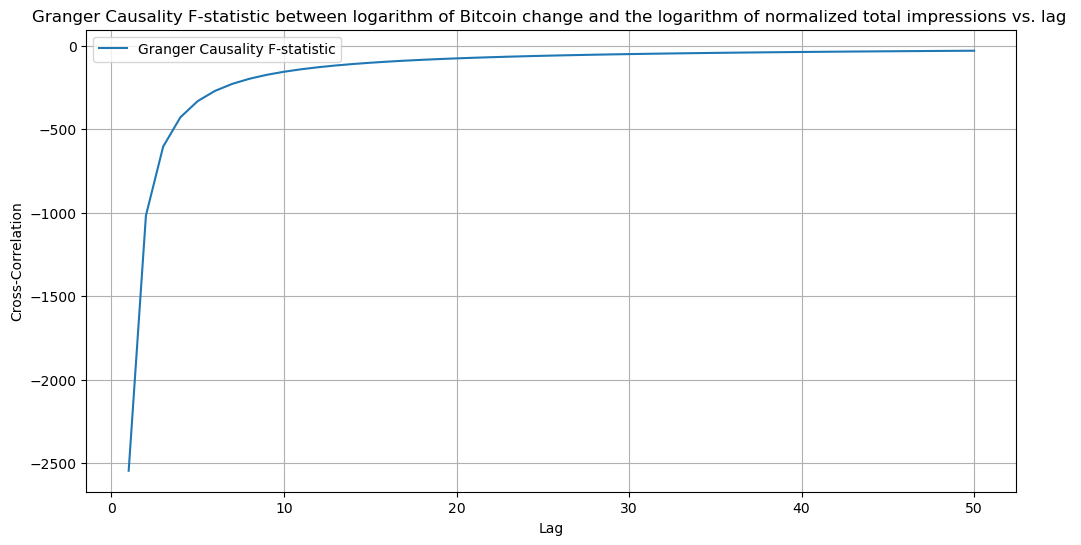

In [13]:
# Granger Causality Test
def granger_causality(X, Y, lags):

    # Helper to calculate RSS
    def calculate_rss(residuals):
        return sum(r ** 2 for r in residuals)

    n = len(Y)
    Y_lags = [[Y[i - lag] for lag in range(1, lags + 1)] for i in range(lags, n)]
    restricted_residuals = [Y[i] - sum(yl) for i, yl in enumerate(Y_lags, start=lags)]
    RSS_r = calculate_rss(restricted_residuals)
    X_lags = [[X[i - lag] for lag in range(1, lags + 1)] for i in range(lags, n)]
    combined_lags = [yl + xl for yl, xl in zip(Y_lags, X_lags)]
    full_residuals = [Y[i] - sum(cl) for i, cl in enumerate(combined_lags, start=lags)]
    RSS_f = calculate_rss(full_residuals)
    k_r = lags
    k_f = 2 * lags
    F = ((RSS_r - RSS_f) / (k_f - k_r)) / (RSS_f / (n - k_f))
    return F

max_lag = 50

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [granger_causality(log_price, log_impressions, lags=lag) for lag in range(1, max_lag + 1)], label='Granger Causality F-statistic')
plt.title('Granger Causality F-statistic between logarithm of Bitcoin price and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [granger_causality(log_volume, log_impressions, lags=lag) for lag in range(1, max_lag + 1)], label='Granger Causality F-statistic')
plt.title('Granger Causality F-statistic between logarithm of Bitcoin volume and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, max_lag + 1), [granger_causality(log_change, log_impressions, lags=lag) for lag in range(1, max_lag + 1)], label='Granger Causality F-statistic')
plt.title('Granger Causality F-statistic between logarithm of Bitcoin change and the logarithm of normalized total impressions vs. lag ')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
# Sliding window
window_size = len(tweet) // 10
correlation = []
for i in range(len(tweet) - window_size):                               #Change this in whatever you want
    correlation.append(tweet['sentiment'].iloc[i:i + window_size].corr(daily_change['change'].iloc[i:i + window_size]))


KeyError: 'sentiment'